# LOAD DBS and Generate final datasets


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv 
from csv import reader
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
%load_ext google.colab.data_table

Assume your path variable, this changes according to each setup.
We consider, for the sake of clarity, that you have used the scripts in folder test_scripts to get these values. If you have computed another set of variables or you have a parsed version of the datasets, yo can jump directly to experiments. 

In [ ]:
datasets ={}
datasets[64]=pd.read_csv(path+"final64.csv") 
datasets[128]=pd.read_csv(path+"final128.csv") 
datasets[256]=pd.read_csv(path+"final256.csv") 
datasets[512]=pd.read_csv(path+"final512.csv") 
datasets[1024]=pd.read_csv(path+"final1024.csv")


##FIPS values and defs
We define here the values so that we return a pass or fail in each test. Using raw values could be another option, yet this way minimise data and assume the official FIPS thresholds to pass them


In [ ]:
# 0 fail, 1 pass
# fips 2 

def check_monobit (x,g):
  for item in json.loads(x): 
    if 9725-9725*g <= int(item) <= 10275+10275*g:
      pass
    else:
      return 0
  return 1  

def check_poker (x,g):
  for item in json.loads(x):
    if 2.16-2.16*g <= float(item) <= 46.17+46.17*g:
      pass
    else:
      return 0
  return 1  


def check_run (x,g):
  for sublist in json.loads(x):
    if 2343-2343*g <= int(sublist[0]) <= 2657+2657*g and 1135-1135*g <= int(sublist[1]) <= 1365+1365*g and 542-542*g <= int(sublist[2]) <= 708+708*g and 251-251*g <= int(sublist[3]) <= 373+373*g and 111-111*g <= int(sublist[4]) <= 201+201*g and 111-111*g <= int(sublist[5]) <= 201+201*g:
       pass
    else: 
      return 0
  return 1
    
def check_long_runs(x,g):
  for sublist in json.loads(x):
    if int(sublist[0]) >= 26+26*g or int(sublist[1]) >= 26+26*g:
      return 0
  return 1 



def check_chi(x,g):
  if x >= 255+(22*g):
      return 0
  return 1


The following function parses the values of the original tests into a single value so that a final CSV is created. Moreover, we drop features and outcomes that are not usable according to previous feature evaluation. We could keep them all but the accuracy and the cost increases, so they are bad.

In [ ]:
import statistics
import json
import joblib

# def createParsedDf_old (df,g):   ## with original darren exps
#   dfr=df
#   dfr['Monobit_'] = dfr['Monobit'].apply(lambda x : check_monobit(x,g) )
#   dfr['Poker_'] = dfr['Poker'].apply(lambda x : check_poker(x,g))
#   dfr['run_n'] = dfr['Run'].apply(lambda x : check_run(x,g))
#   dfr['long_run_'] = dfr['Long run'].apply(lambda x : check_long_runs(x,g))
#   dfr['fips_out']= dfr['Monobit_'] & dfr['Poker_'] & dfr['run_n'] & dfr['long_run_']
#   dfr['fips_out']=  dfr['fips_out'].astype(int)

#   dfr['block_freq'] = dfr['Block Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#   dfr['freq_average'] = dfr['Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#   dfr['cumu_sum'] = dfr['Cumulative Sums'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#   dfr['runs_n'] = dfr['Runs'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))  
#   dfr['longest_run'] = dfr['Longest Run'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))  
#   dfr['rank_n'] = dfr['Rank'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))  
#   dfr['fft_n'] = dfr['FFT'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
#   #dfr['NonOverlapping_template_mean'] = dfr['NonOverlapping Template'].apply(lambda x : statistics.mean([float(i) for i in eval(x)[0]])) 
#   #dfr['NonOverlapping_template_std'] = dfr['NonOverlapping Template'].apply(lambda x : statistics.stdev([float(i) for i in eval(x)[0]])) 
#   dfr['overlapping_template'] = dfr['Overlapping Template'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
#   #dfr['universal_n'] = dfr['Universal'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
#   dfr['Approximate_Entropy'] = dfr['Approximate Entropy'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
#   dfr['serial_n'] = dfr['Serial'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
#   dfr['Linear_Complexity'] = dfr['Linear Complexity'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 

#   dfr = dfr.drop(['Random Excursions', 'Random Excursions Variant','P-val Z', 'P-val Chi', 'Monobit','Poker','Run','Long run','Frequency','Block Frequency','Cumulative Sums','Runs','Longest Run','Rank','FFT','NonOverlapping Template','Overlapping Template','Universal','Approximate Entropy','Serial','Linear Complexity'], axis=1)
#   dfr = dfr.drop([' size'],axis=1)
#   dfr.rename(columns={" Original": "Original"})
#   normalized_dfr=(dfr-dfr.min())/(dfr.max()-dfr.min())


#   return normalized_dfr


##The following function transforms the complex outcomes of the tests into a single numerical variable and normalises the dataframe. It also removes some non-relevant features. 
def createParsedDf_min (df,g,gh):
    dfr=df
    dfr['Monobit_'] = dfr['Monobit'].apply(lambda x : check_monobit(x,g) )
    dfr['Poker_'] = dfr['Poker'].apply(lambda x : check_poker(x,g))
    dfr['Run_n'] = dfr['Run'].apply(lambda x : check_run(x,g))
    dfr['Long_run_'] = dfr['Long run'].apply(lambda x : check_long_runs(x,g))
    dfr['Fips_out']= dfr['Monobit_'] & dfr['Poker_'] & dfr['Run_n'] & dfr['Long_run_']
    dfr['Fips_out']=  dfr['Fips_out'].astype(int)

    dfr['Block_freq'] = dfr['Block Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Freq_average'] = dfr['Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Cumu_sum'] = dfr['Cumulative Sums'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Ov_temp'] = dfr['Overlapping Template'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 

    dfr.rename(columns={'jarque-bera': 'Jarque-Bera'}, inplace=True)
    dfr.rename(columns={'shapiro': 'Shapiro-Wilk'}, inplace=True)

    if gh!=0:
      dfr['Chi_score'] = dfr['Chi-score'].apply(lambda x : check_chi(x,gh))
    else:
      dfr['Chi_score'] = dfr['Chi-score']   

    dfr = dfr.drop(['Monobit','Chi-score','Poker','squared_hist','Iterations','Run','Long run','Frequency','Block Frequency','Cumulative Sums','Overlapping Template'], axis=1)
    dfr = dfr.drop([' size'],axis=1)
    dfr.rename(columns={" Original": "Original"})
    cols_to_norm = ['Entropy',
 'Jarque-Bera',
 'Shapiro-Wilk',
 'Block_freq',
 'Freq_average',
 'Cumu_sum',
 'Ov_temp',
 'Chi_score']
    dfr[cols_to_norm] = dfr[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


    return dfr


# def createParsedDf (df,g,gh):
#     dfr=df
#     dfr['Monobit_'] = dfr['Monobit']
#     dfr['Poker_'] = dfr['Poker']
#     dfr['run_n'] = dfr['Run']
#     dfr['long_run_'] = dfr['Long run']
#     dfr['fips_out']= dfr['Monobit_'] & dfr['Poker_'] & dfr['run_n'] & dfr['long_run_']
#     dfr['fips_out']=  dfr['fips_out'].astype(int)

#     dfr['block_freq'] = dfr['Block Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#     dfr['freq_average'] = dfr['Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#     dfr['cumu_sum'] = dfr['Cumulative Sums'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
#     dfr['overlapping_template'] = dfr['Overlapping Template'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 
    
#     if gh!=0:
#       dfr['Chi_score'] = dfr['Chi-score'].apply(lambda x : check_chi(x,gh))
#     else:
#       dfr['Chi_score'] = dfr['Chi-score']   

#     dfr = dfr.drop(['Monobit','Chi-score','Poker','squared_hist','Iterations','Run','Long run','Frequency','Block Frequency','Cumulative Sums','Overlapping Template'], axis=1)
#     dfr = dfr.drop([' size'],axis=1)
#     dfr.rename(columns={" Original": "Original"})
#     #normalized_dfr=(dfr-dfr.min())/(dfr.max()-dfr.min())
#     cols_to_norm = ['Entropy',
#  'jarque-bera',
#  'shapiro',
#  'Monobit_',
#  'Poker_',
#  'run_n',
#  'long_run_',
#  'fips_out',
#  'block_freq',
#  'freq_average',
#  'cumu_sum',
#  'overlapping_template',
#  'Chi_score']
#     dfr[cols_to_norm] = dfr[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#     return dfr

  ## LONG RUN DELETE NO SIRVE






## Data Parser
Here, we create the final datasets by using the def functions above. Careful with the values of the gamma fips values and gamma hedge values. Current values are kept as in the paper.

In [ ]:
## TEST FOR ALL GAMMA VALUES. DEFAULT IS 0 for gammafips and 0 for gammahedge. gammahedge 0 is like gamma 1 in original hedge
## values for testing and playing
## gamma hedge like original, from 0.1 to e.g. 2 or more, intervals of 0.1
# gamma_fips_values = [0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2]
# gamma_hedge_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
gamma_fips_values = [0] ## after testing, higher values make pass more enc than comp so proportion is better. The higher the file, the more tolerance to have less strict values in fips, since comp will not pass them anyway.
## higher gamma fips than 0.1 does not yeld much better outcomes
gamma_hedge_values = [2] ##  there is a sweet spot between 2 and 3, but 3 is worse or shows no improvement.


datasets_test={} ## we this as backup for the different tests and not overwrite original

for val in datasets:
  for gammafips in gamma_fips_values:
    for gammahedge in gamma_hedge_values: 
      datasets_test[val] = createParsedDf_min(datasets[val],gammafips,gammahedge)



#HEDGE

In [ ]:
def createParsedDf_hedge (df,g,gh):
    dfr=df
    dfr['Monobit_'] = dfr['Monobit'].apply(lambda x : check_monobit(x,g) )
    dfr['Poker_'] = dfr['Poker'].apply(lambda x : check_poker(x,g))
    dfr['Run_n'] = dfr['Run'].apply(lambda x : check_run(x,g))
    dfr['Long_run_'] = dfr['Long run'].apply(lambda x : check_long_runs(x,g))
    dfr['Fips_out']= dfr['Monobit_'] & dfr['Poker_'] & dfr['Run_n'] & dfr['Long_run_']
    dfr['Fips_out']=  dfr['Fips_out'].astype(int)

    dfr['Block_freq'] = dfr['Block Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Freq_average'] = dfr['Frequency'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Cumu_sum'] = dfr['Cumulative Sums'].apply(lambda x : sum([float(i) for i in eval(x)[0]]))   
    dfr['Ov_temp'] = dfr['Overlapping Template'].apply(lambda x : sum([float(i) for i in eval(x)[0]])) 

    dfr.rename(columns={'jarque-bera': 'Jarque-Bera'}, inplace=True)
    dfr.rename(columns={'shapiro': 'Shapiro-Wilk'}, inplace=True)

    
    dfr['Chi_score'] = dfr['Chi-score'].apply(lambda x : check_chi(x,gh))
    

    dfr = dfr.drop(['Monobit','Chi-score','Poker','squared_hist','Iterations','Run','Long run','Frequency','Block Frequency','Cumulative Sums','Overlapping Template'], axis=1)
    dfr = dfr.drop([' size'],axis=1)
    dfr.rename(columns={" Original": "Original"})
    cols_to_norm = ['Entropy',
 'Jarque-Bera',
 'Shapiro-Wilk',
 'Block_freq',
 'Freq_average',
 'Cumu_sum',
 'Ov_temp',
 'Chi_score']
    dfr[cols_to_norm] = dfr[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


    return dfr

In [ ]:
## TEST FOR ALL GAMMA VALUES. DEFAULT IS 0 for gammafips and 0 for gammahedge. gammahedge 0 is like gamma 1 in original hedge
## values for testing and playing
## gamma hedge like original, from 0.1 to e.g. 2 or more, intervals of 0.1
# gamma_fips_values = [0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2]
# gamma_hedge_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
gamma_fips_values = [0] ## after testing, higher values make pass more enc than comp so proportion is better. The higher the file, the more tolerance to have less strict values in fips, since comp will not pass them anyway.
## higher gamma fips than 0.1 does not yeld much better outcomes
gamma_hedge_values = [0,1,2] ##  there is a sweet spot between 2 and 3, but 3 is worse or shows no improvement. so 2.5 seems ok. when using RF we need to see if it is worth to enforce this or set it to 0


#Monobit_ Poker_ run_n long_run_
datasets_test={} ## we this as backup for the different tests and not overwrite original

for val in datasets:
  for gammafips in gamma_fips_values:
    for gammahedge in gamma_hedge_values: 
      datasets_test[val] = createParsedDf_hedge(datasets[val],gammafips,gammahedge)
      dft= datasets_test[val].loc[datasets_test[val]['Filetype'] == 1] ## 1 is enc
      pass_enc = len((dft [(dft['Chi_score'] == 1) & (dft['Fips_out'] == 1)]))
      #pass_enc = len((dft [(dft['run_n'] == 1)])) / len(dft.index)
      #print("Percentage of passing vals for enc "+str(val)+" "+str(gammafips)+" "+str(gammahedge)+" ", pass_enc )
      dfc= datasets_test[val].loc[datasets_test[val]['Filetype'] == 0] ## 0 is comp
      pass_comp = len(dfc.index)-len((dfc [(dfc['Chi_score'] == 1) & (dfc['Fips_out'] == 1)]))## any other combination of outcomes means compressed, since both are not passed.
      total=(pass_enc+pass_comp)/(len(dft.index)+len(dfc.index))
      print(pass_enc,pass_comp,len(dfc.index))
      print("Percentage of passing vals "+str(val)+" "+str(gammafips)+" "+str(gammahedge)+" ", total)
      #print("Pass total (not usable as metric)",pass_enc-pass_comp)

4585 9349 9600
Percentage of passing vals 64 0 0  0.7257291666666666
7608 9040 9600
Percentage of passing vals 64 0 1  0.8670833333333333
8783 8760 9600
Percentage of passing vals 64 0 2  0.9136979166666667
2167 4756 4800
Percentage of passing vals 128 0 0  0.7211458333333334
3585 4670 4800
Percentage of passing vals 128 0 1  0.8598958333333333
4130 4585 4800
Percentage of passing vals 128 0 2  0.9078125
972 2394 2400
Percentage of passing vals 256 0 0  0.70125
1617 2386 2400
Percentage of passing vals 256 0 1  0.8339583333333334
1859 2374 2400
Percentage of passing vals 256 0 2  0.881875
397 1200 1200
Percentage of passing vals 512 0 0  0.6654166666666667
635 1200 1200
Percentage of passing vals 512 0 1  0.7645833333333333
719 1200 1200
Percentage of passing vals 512 0 2  0.7995833333333333
118 600 600
Percentage of passing vals 1024 0 0  0.5983333333333334
191 600 600
Percentage of passing vals 1024 0 1  0.6591666666666667
220 600 600
Percentage of passing vals 1024 0 2  0.6833333333

##  Statistical plots

In [ ]:
import matplotlib.pyplot as plt
import csv 
from csv import reader
import pandas as pd
import seaborn as sns
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter
import matplotlib.patheffects as PathEffects
%matplotlib inline
%load_ext google.colab.data_table

import os,sys

# original

# 0 bin
# 1 img
# 2 mp3
# 3 pdf
# 4 txt
# 5 video

# filetype

# 0 compressed
# 1 encrypted

#00,01,02,03,04,05,10,11,12,13,14,15  codes

def get_title(key):
   if key =="1":
     return "Encrypted"
   elif key== "00":
     return "Compressed Binary"
   elif key== "01":
     return "Compressed Image" 
   elif key== "02":
     return "Compressed MP3" 
   elif key== "03":
     return "Compressed PDF" 
   elif key== "04":
     return "Compressed TXT" 
   elif key== "05":
     return "Compressed Video" 
   elif key== "10":
     return "Encrypted Binary" 
   elif key== "11":
     return "Encrypted Image" 
   elif key== "12":
     return "Encrypted MP3" 
   elif key== "13":
     return "Encrypted PDF" 
   elif key== "14":
     return "Encrypted TXT" 
   elif key== "15":
     return "Encrypted Video" 
   else:
     return "Error title" 




def dotheplotall(d, size):  ## just a fancy boxplot
  #to plot all we need normalized values 
  for key in d: ## only one df in d so its ok. 
    #normalized_df=(d[key]-d[key].min())/(d[key].max()-d[key].min()) ## for this we should normalize entire db, not step by step because its biased. 
    normalized_df=d[key] ## we asume we previously normalized dataset
    fig=plt.figure(figsize=(12,8))
    bplot = sns.boxplot(
                    data=normalized_df, 
                    width=0.5,
                    palette="tab10")
    # bplot=sns.swarmplot(
    #                   data=normalized_df, 
    #                   marker='o', 
    #                   alpha=0.5,
    #                   color='black')
    ## HERE TRANSFORM NUMBERS INTO STRINGS FOR TITLE LATER.
    string_title=get_title(key)
    bplot.axes.set_title("Value distribution -- "+string_title+" -- "+str(size)+" KB ",
                        fontsize=28)

    bplot.set_xlabel("Features", 
                    fontsize=26,labelpad=20)
    plt.xticks(rotation=60)
    
    bplot.set_ylabel("Values",
                    fontsize=26,labelpad=20)
    
    bplot.tick_params(labelsize=26)

    # output file name
    #plot_file_name="census_times.jpg"
    
    # save as jpeg
    plt.savefig(path+"_"+string_title+"_"+str(size)+"_box.png", bbox_inches='tight')

def dotheplotall_rotated(d, size):  ## just a fancy boxplot
  #to plot all we need normalized values 
  for key in d: ## only one df in d so its ok. 
    #normalized_df=(d[key]-d[key].min())/(d[key].max()-d[key].min()) ## for this we should normalize entire db, not step by step because its biased. 
    normalized_df=d[key] ## we asume we previously normalized dataset
    fig=plt.figure(figsize=(12,8))
    bplot = sns.boxplot(
                    data=normalized_df, 
                    width=0.5,
                    color="skyblue",
                    orient='h')
    
    # bplot = sns.stripplot(
    #                 data=normalized_df, 
    #                 jitter=True, linewidth=1,
    #                 color="blue",
    #                 orient='h')
    # bplot=sns.swarmplot(
    #                   data=normalized_df, 
    #                   marker='o', 
    #                   alpha=0.5,
    #                   color='black')
    ## HERE TRANSFORM NUMBERS INTO STRINGS FOR TITLE LATER.
    string_title=get_title(key)
    #bplot.axes.set_title("Value distribution -- "+string_title+" -- "+str(size)+" KB ",fontsize=28)

    #bplot.set_xlabel("Values", fontsize=26,labelpad=20)
    #plt.xticks(rotation=60)
    
    #bplot.set_ylabel("Features",fontsize=26,labelpad=20)
    
    bplot.tick_params(labelsize=26)

    # output file name
    #plot_file_name="census_times.jpg"
    
    # save as jpeg
    plt.savefig(path+"_"+string_title+"_"+str(size)+"_box.png", bbox_inches='tight')

def dotheplotall_violin(d, size):  ## just a fancy boxplot
  #to plot all we need normalized values 
  for key in d: ## only one df in d so its ok. 
    #normalized_df=(d[key]-d[key].min())/(d[key].max()-d[key].min()) ## for this we should normalize entire db, not step by step because its biased. 
    normalized_df=d[key] ## we asume we previously normalized dataset
    fig=plt.figure(figsize=(12,8))
    bplot = sns.violinplot(
                    data=normalized_df, 
                    #width=0.5,
                    color="blue",
                    orient='h')
    bplot = sns.stripplot(
                    data=normalized_df, 
                    jitter=True, linewidth=1,
                    color="blue",
                    orient='h')
    # bplot=sns.swarmplot(
    #                   data=normalized_df, 
    #                   marker='o', 
    #                   alpha=0.5,
    #                   color='black')
    ## HERE TRANSFORM NUMBERS INTO STRINGS FOR TITLE LATER.
    string_title=get_title(key)
    bplot.axes.set_title("Value distribution -- "+string_title+" -- "+str(size)+" KB ",
                        fontsize=28)

    bplot.set_xlabel("Values", 
                    fontsize=26,labelpad=20)
    #plt.xticks(rotation=60)
    
    bplot.set_ylabel("Features",
                    fontsize=26,labelpad=20)
    
    bplot.tick_params(labelsize=26)

    # output file name
    #plot_file_name="census_times.jpg"
    
    # save as jpeg
    plt.savefig(path+"_"+string_title+"_"+str(size)+"_box.png", bbox_inches='tight')

def dotheplotall_strip(d, size):  ## just a fancy boxplot
  #to plot all we need normalized values 
  for key in d: ## only one df in d so its ok. 
    #normalized_df=(d[key]-d[key].min())/(d[key].max()-d[key].min()) ## for this we should normalize entire db, not step by step because its biased. 
    normalized_df=d[key] ## we asume we previously normalized dataset
    fig=plt.figure(figsize=(12,8))
    
    bplot = sns.stripplot(
                    data=normalized_df, 
                    jitter=True, linewidth=1,
                    color="blue",
                    orient='h')
    # bplot=sns.swarmplot(
    #                   data=normalized_df, 
    #                   marker='o', 
    #                   alpha=0.5,
    #                   color='black')
    ## HERE TRANSFORM NUMBERS INTO STRINGS FOR TITLE LATER.
    #string_title=get_title(key)
    #bplot.axes.set_title("Value distribution -- "+string_title+" -- "+str(size)+" KB ",fontsize=28)

    #bplot.set_xlabel("Values", fontsize=26,labelpad=20)
    #plt.xticks(rotation=60)
    
    #bplot.set_ylabel("Features",fontsize=26,labelpad=20)
    
    bplot.tick_params(labelsize=26)

    # output file name
    #plot_file_name="census_times.jpg"
    
    # save as jpeg
    plt.savefig(path+"_"+string_title+"_"+str(size)+"_box.png", bbox_inches='tight')

def strip_col_to_dict (df, d, typed, filety):  ## check the drop, THIS IS WITH FIPS OUT
    if typed ==0: ## only if compressed we distinguish between different data files. Comment this if to do a plot per each original filetype and enc.
      filename=str(typed)+str(filety)
      d[filename]=df.loc[df[' Original'] == filety]
      d[filename]=d[filename].loc[df['Filetype'] == typed]
    else:
      filename=str(typed)
      d[filename]=df.loc[df['Filetype'] == typed]
    
    d[filename]=d[filename].drop(['Filetype',' Original','Monobit_','Poker_','Run_n','Long_run_','Fips_out'],axis=1)                       
    d[filename].reset_index(drop=True, inplace=True)
    #d[filename]= d[filename].loc[d[filename][d[filename].columns[1]] == filety].drop(d[filename].columns, axis=1)
    #d[filename].reset_index(drop=True, inplace=True)
    #d[filename].columns = [filename]
    #print(filename)
    return d



The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


<ipython-input-26-0add475db9fb>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(12,8))
<ipython-input-26-0add475db9fb>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(12,8))
<ipython-input-26-0add475db9fb>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure

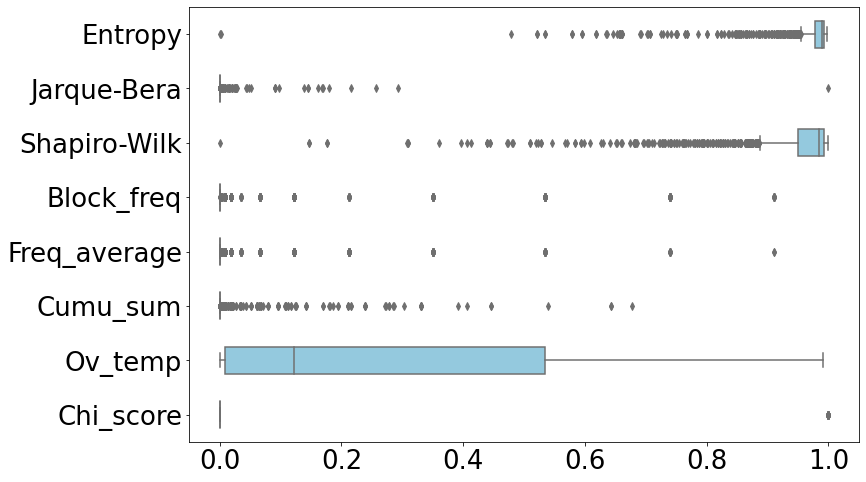

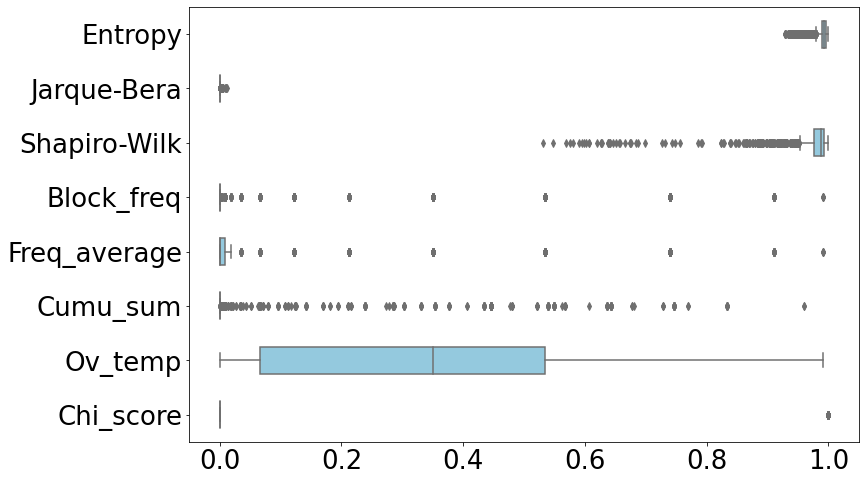

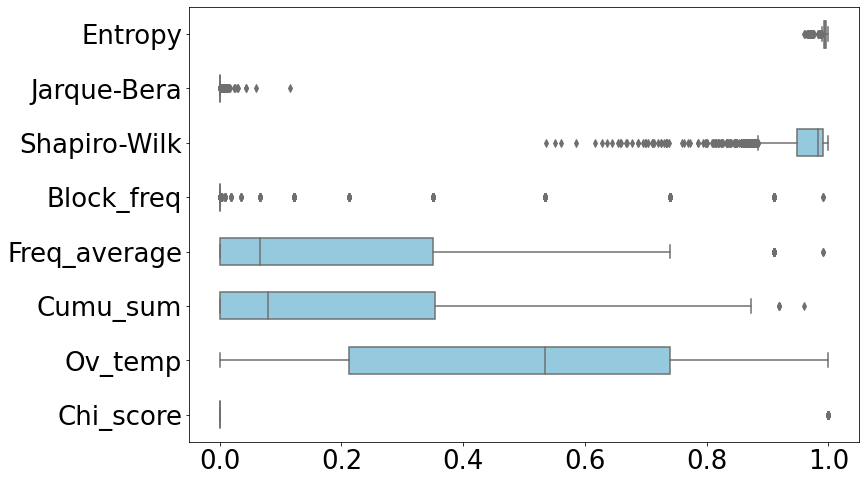

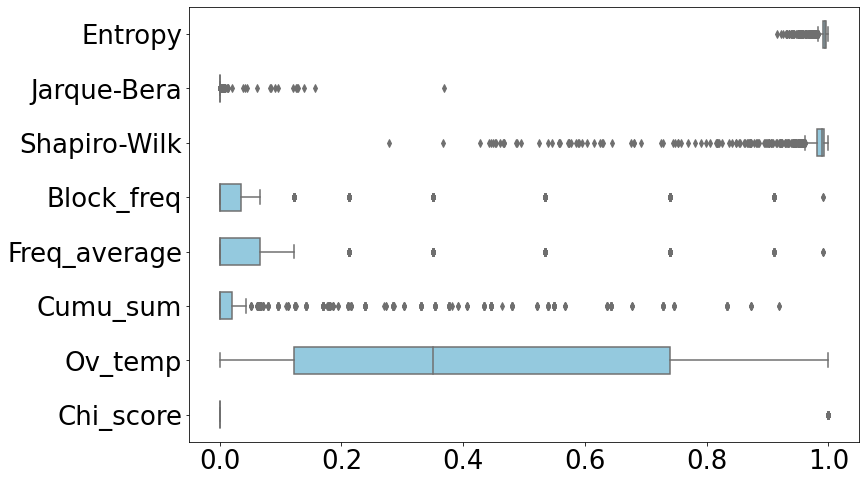

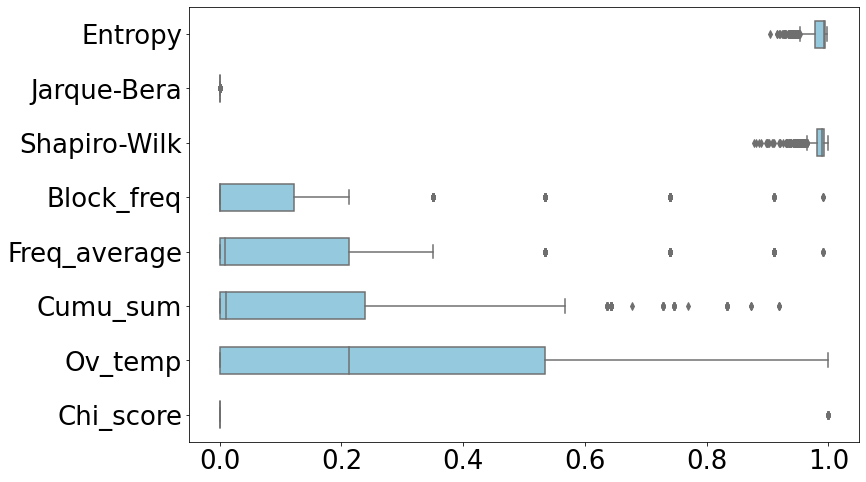

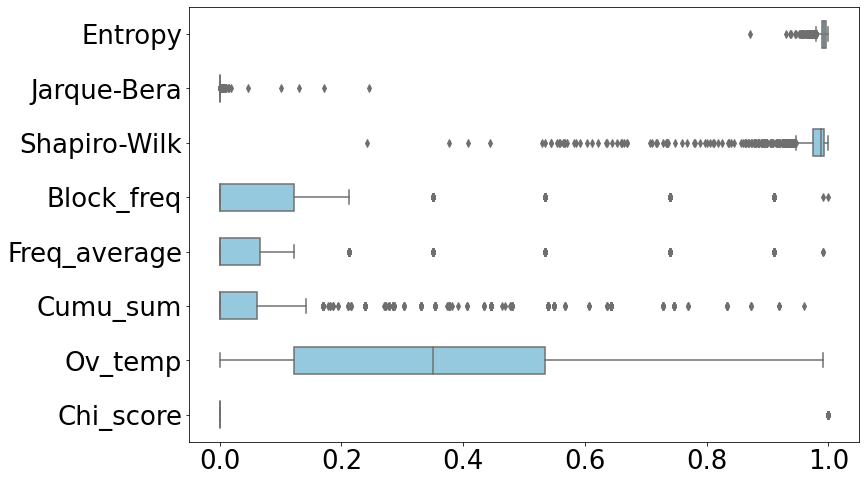

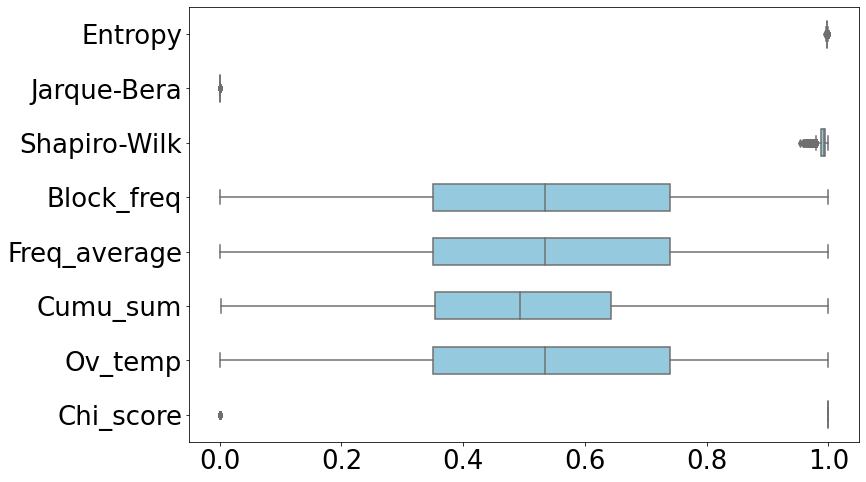

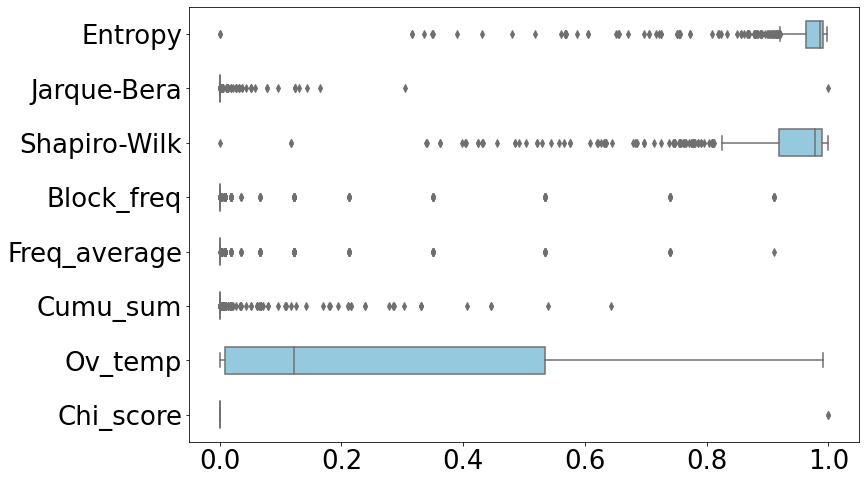

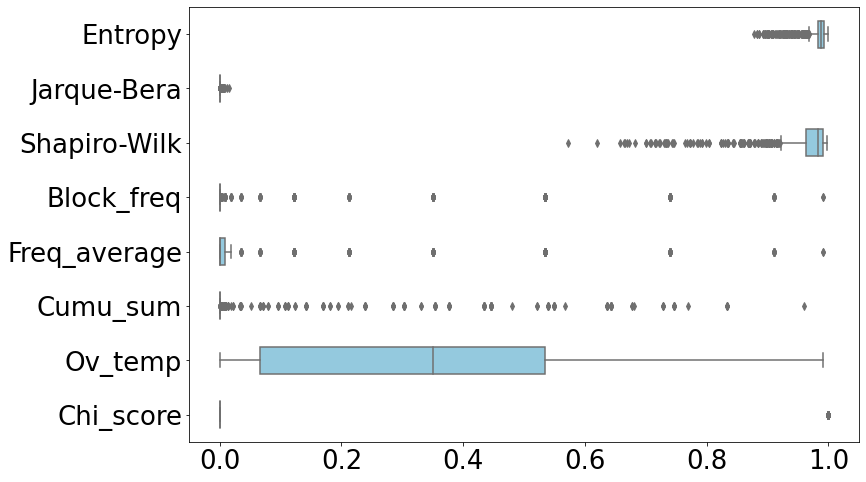

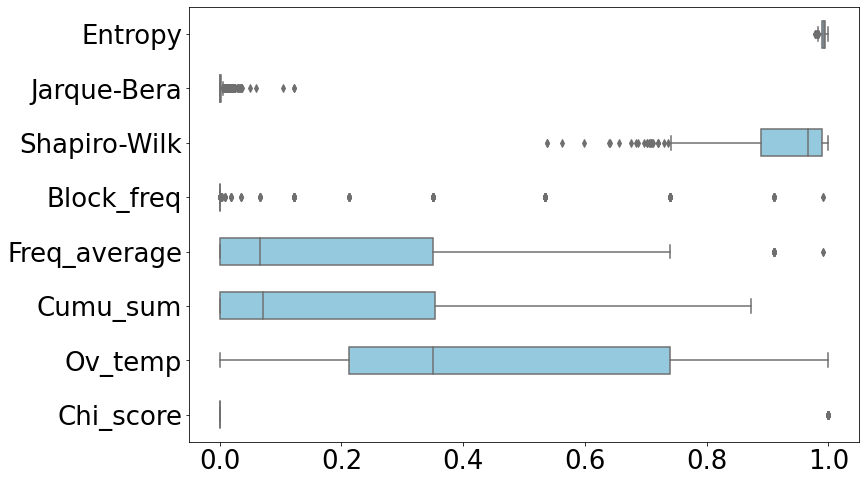

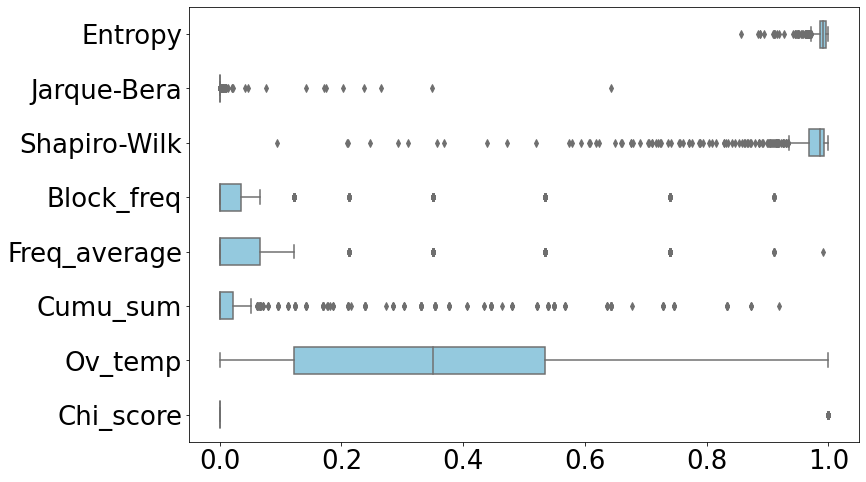

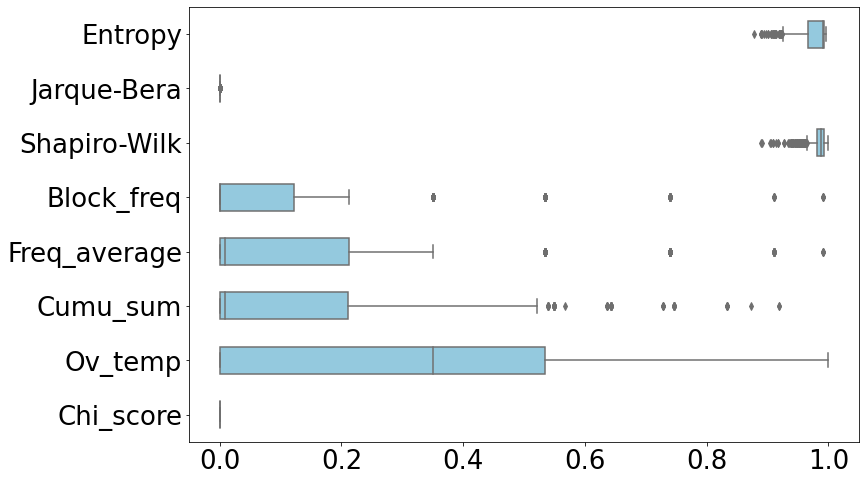

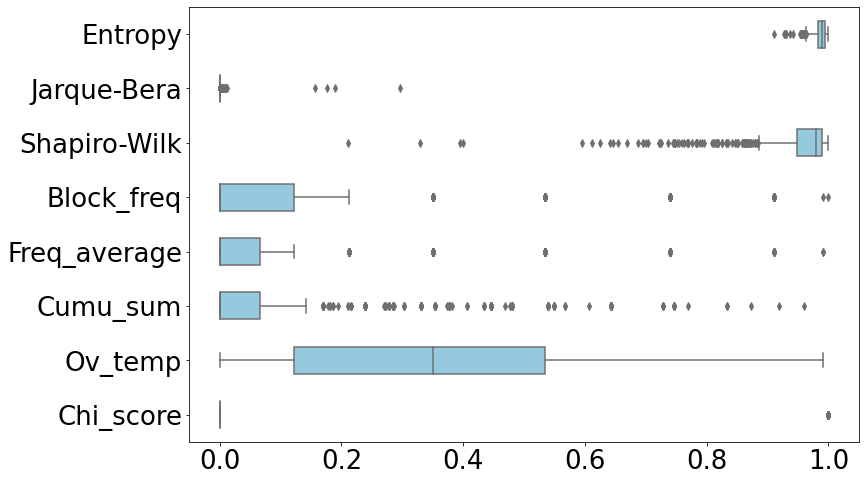

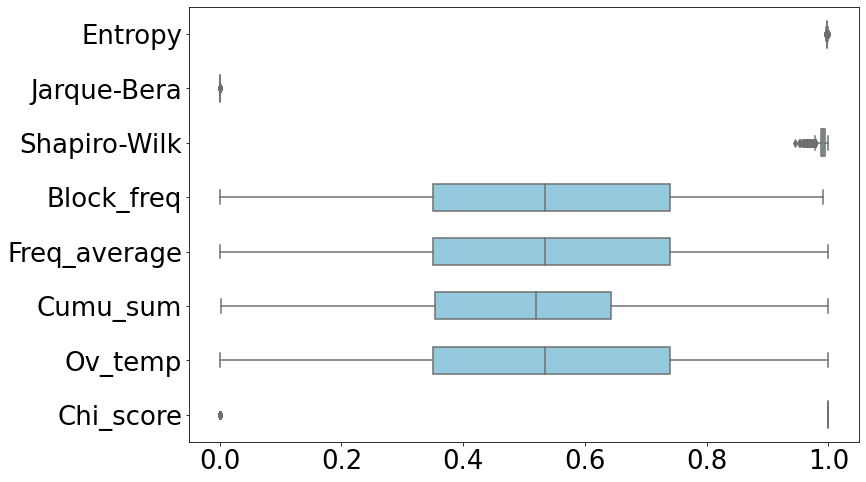

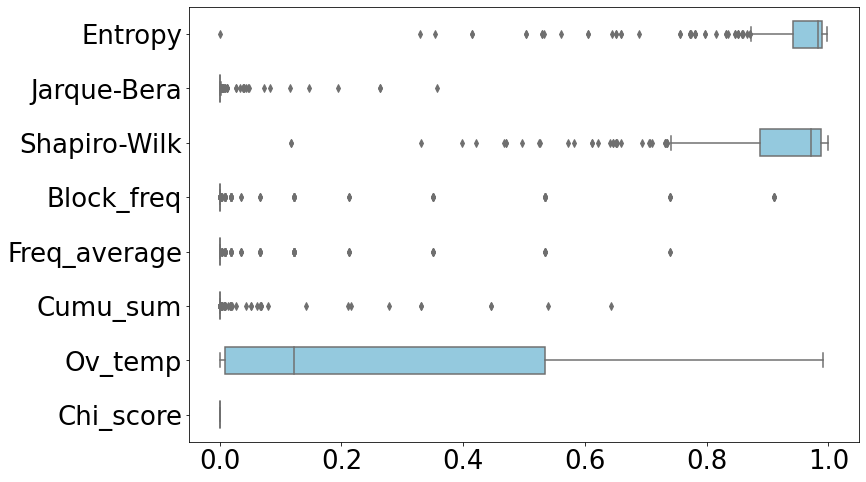

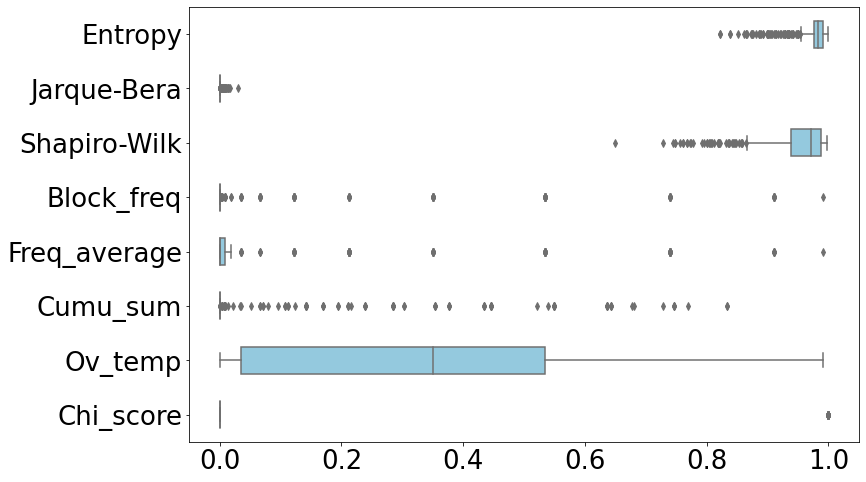

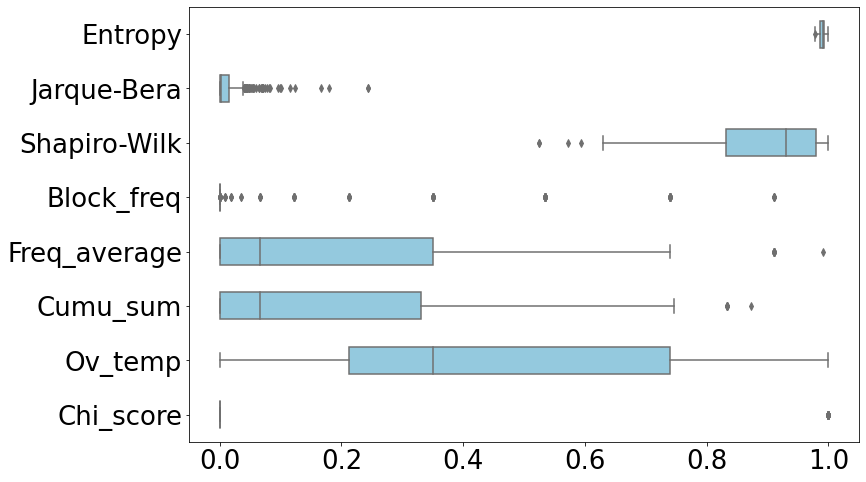

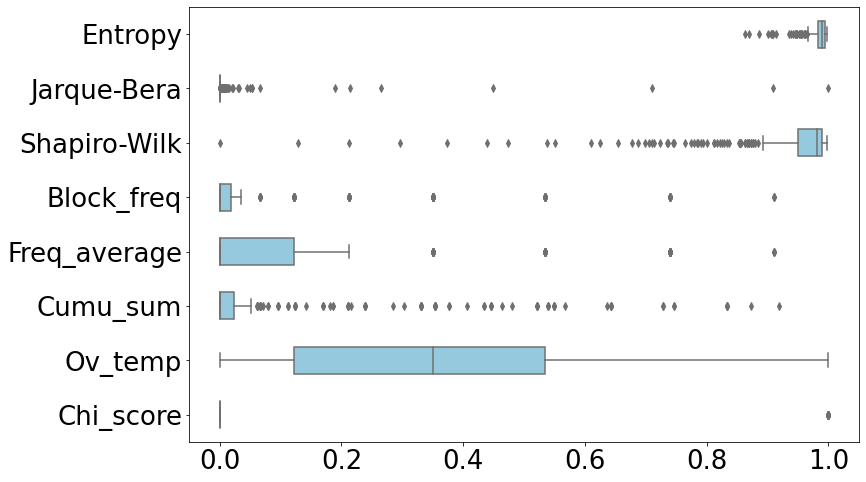

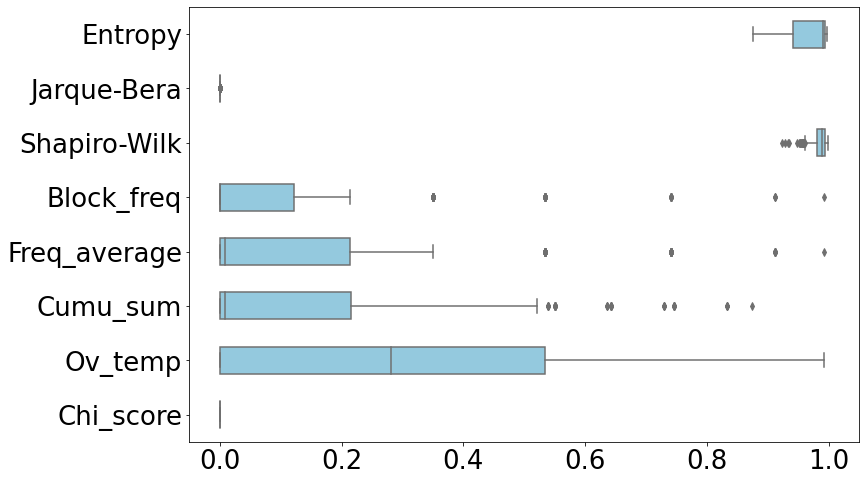

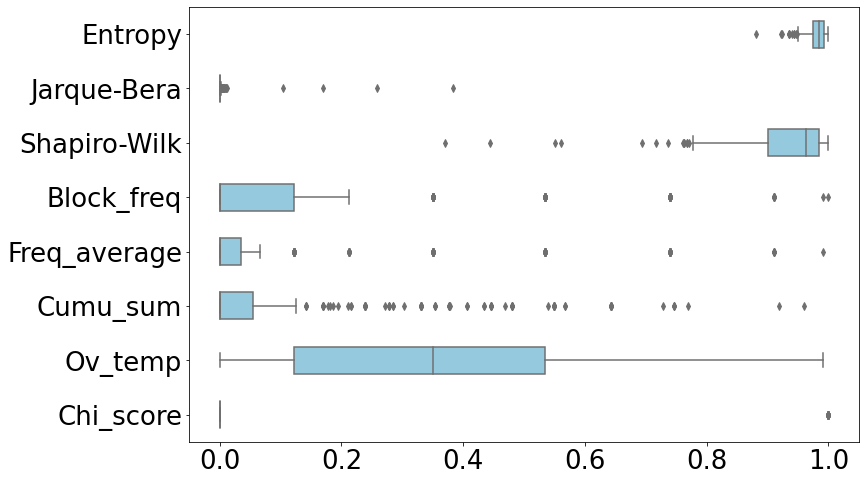

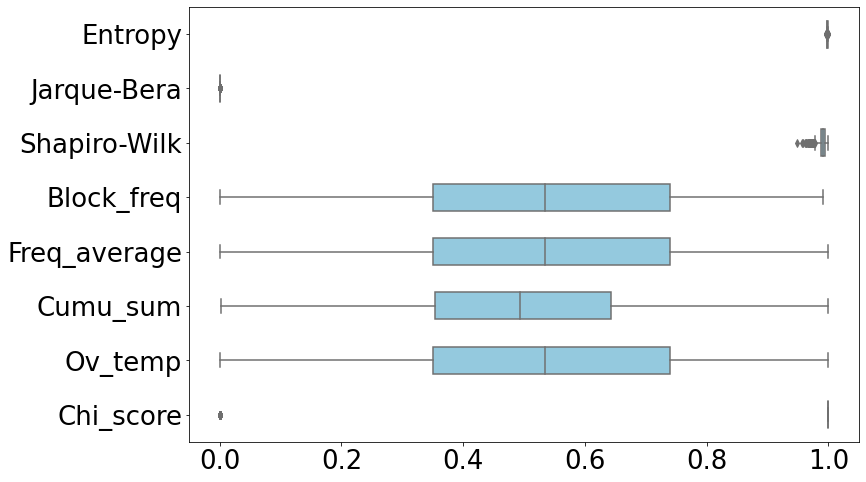

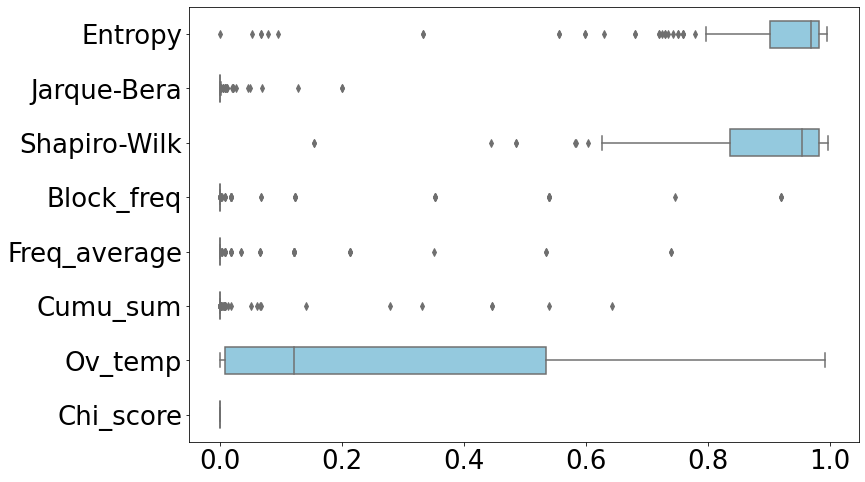

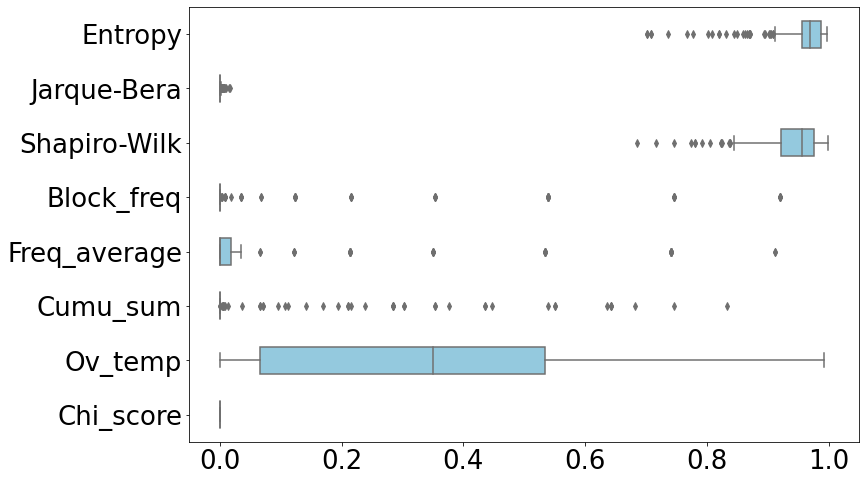

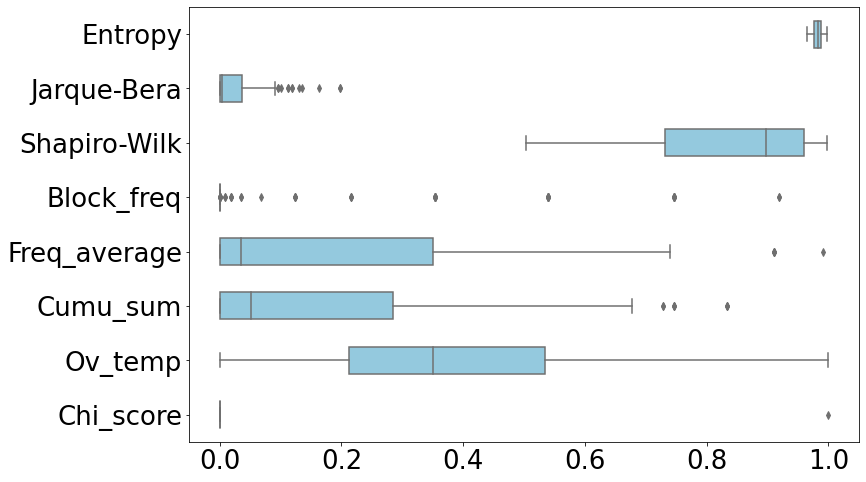

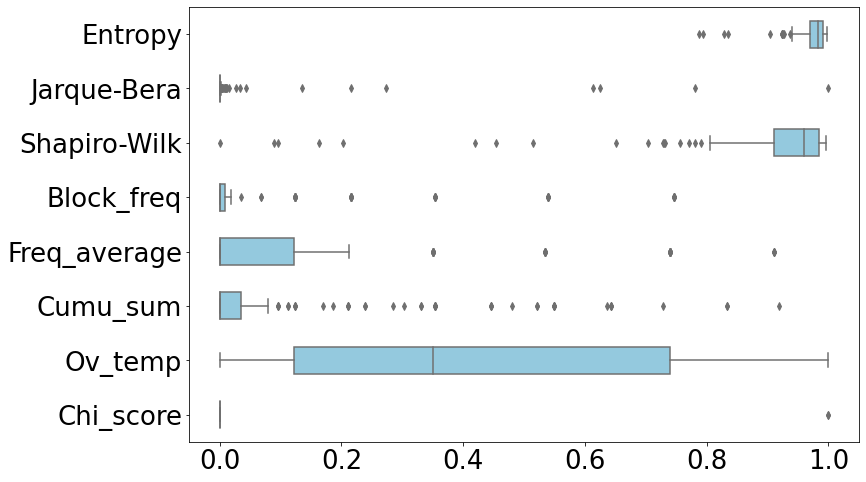

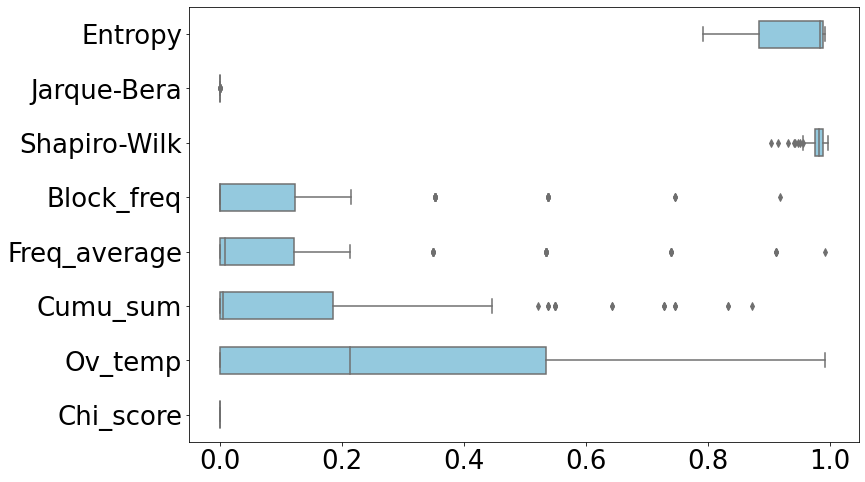

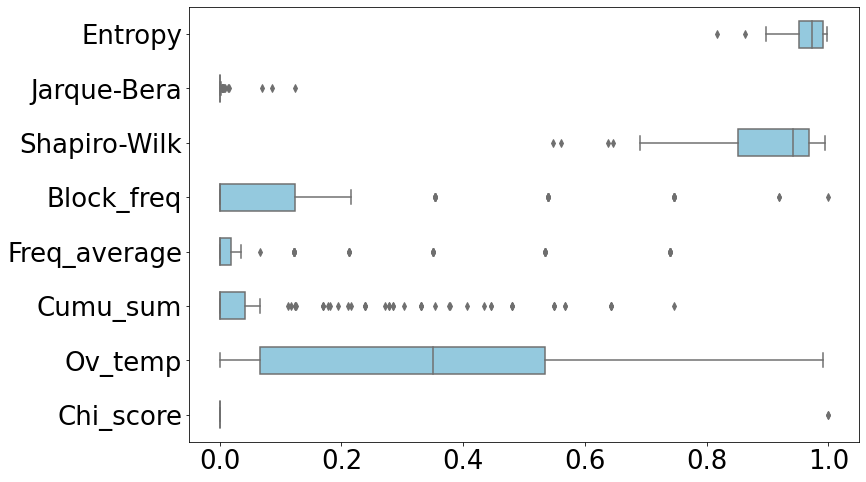

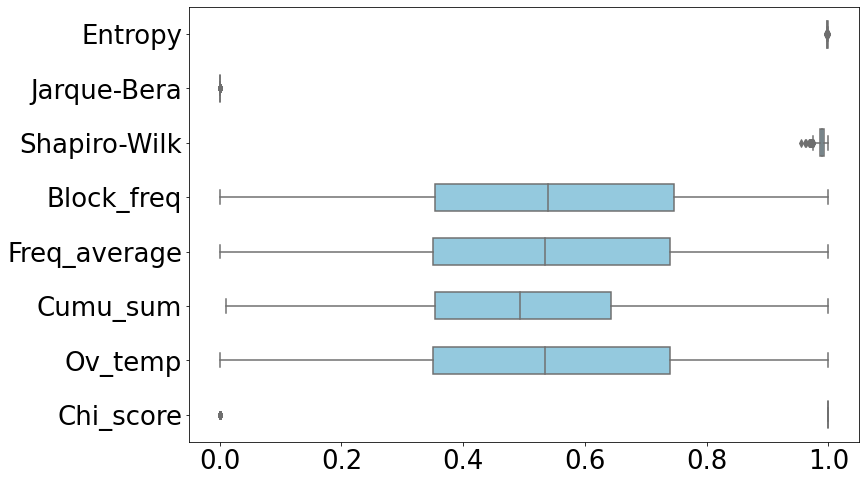

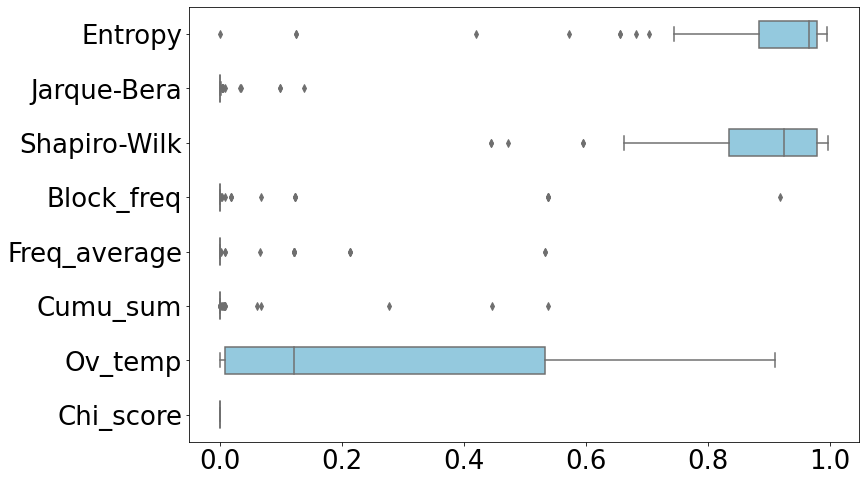

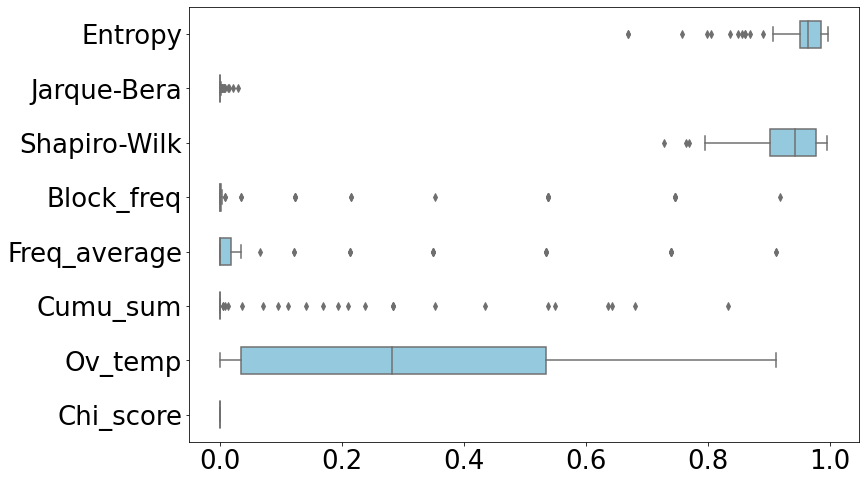

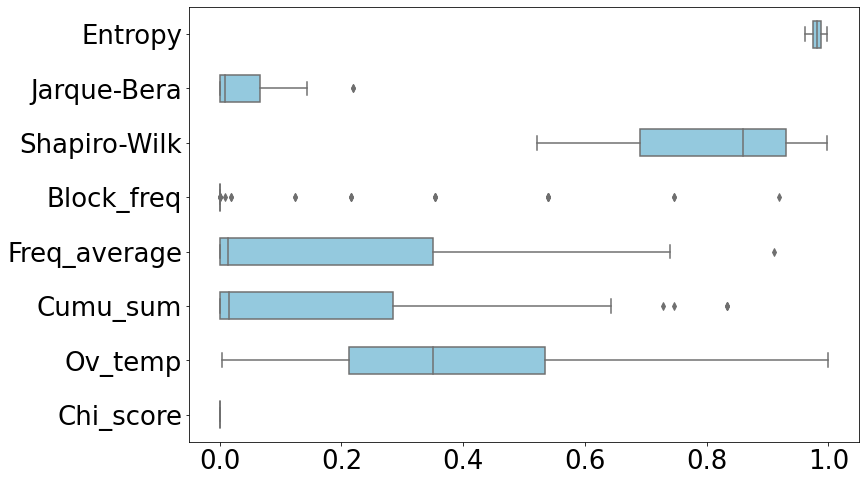

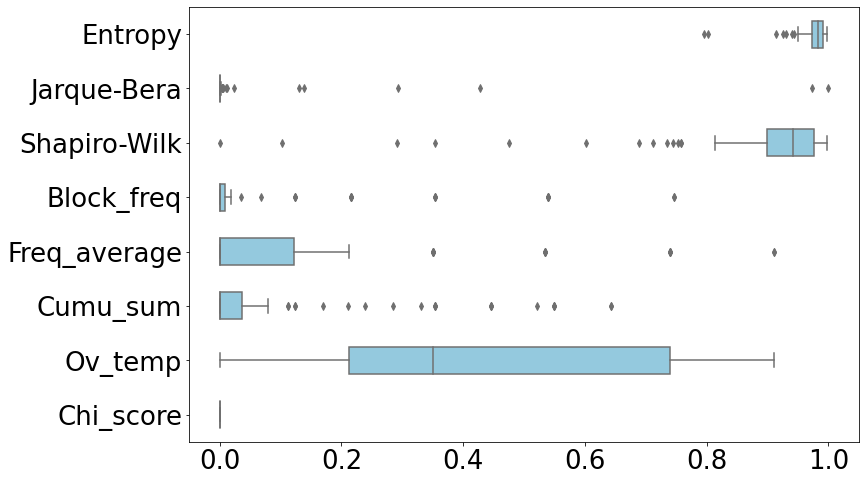

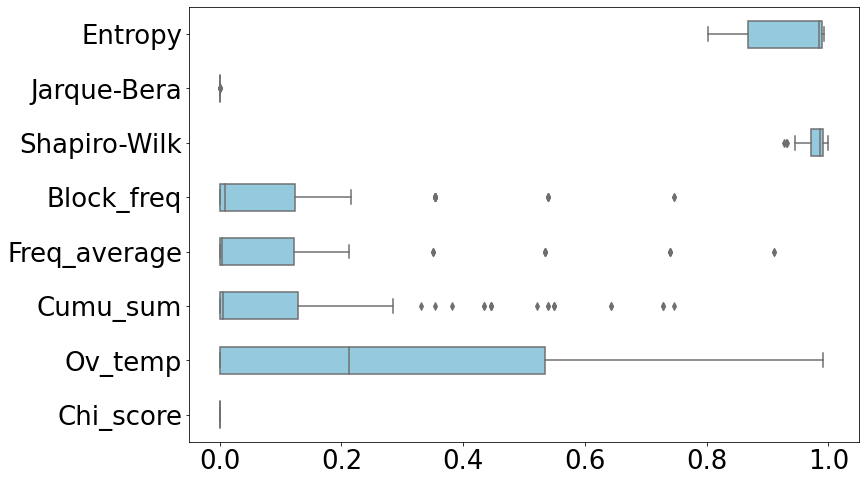

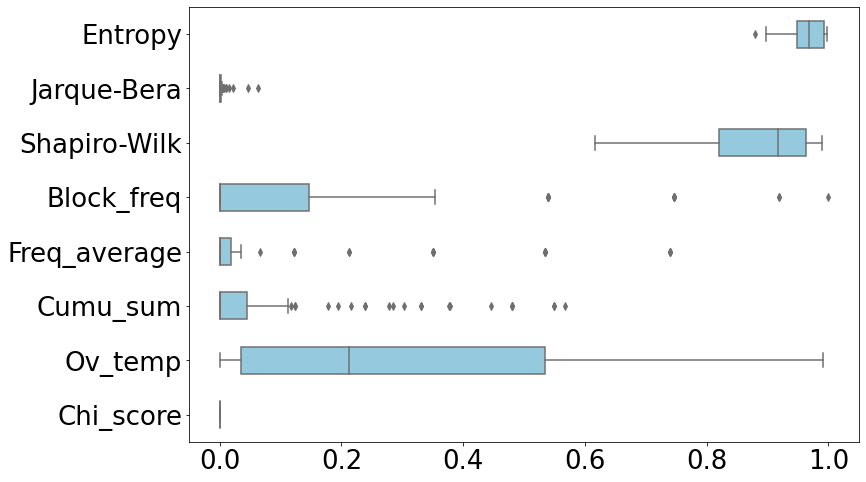

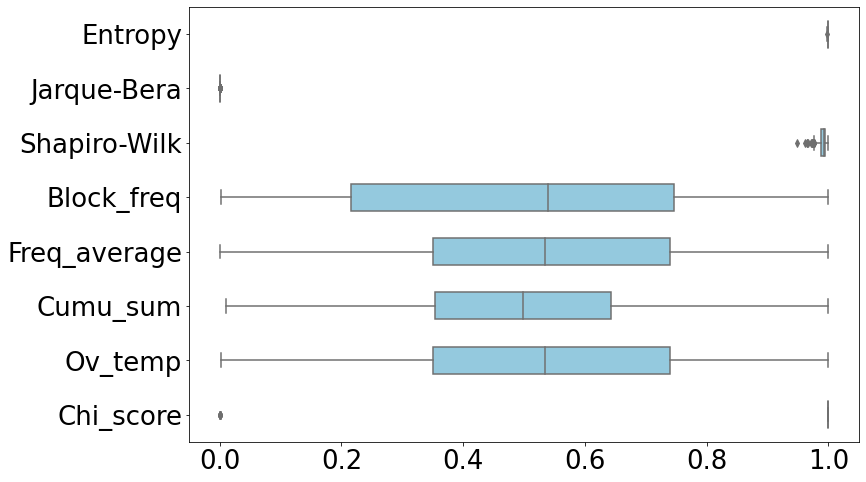

In [ ]:
# original

# 0 bin
# 1 img
# 2 mp3
# 3 pdf
# 4 txt
# 5 video

# filetype

# 0 compressed
# 1 encrypted

#00,01,02,03,04,05,10,11,12,13,14,15  codes

filetypes = [0,1,2,3,4,5]
typeds = [0,1]


for key in datasets_test:
  d_plot={}
  for val in typeds:
    for fil in filetypes:  
      d_plot=strip_col_to_dict(datasets_test[key], d_plot, val, fil)
  dotheplotall_rotated(d_plot, key)

# Specific test for FIPS
The above did not include FIPS. We are doing a specific test for FIPS here to check what is the behaviour of FIPS according to the data size. This strenghtens why we do the experiments size-based. 

part 1 analysis of test. We see that depending on the gamma and due the small values applied in some of them, we see that some graphics have particular behaviour like long run. This is due the fact that the threshold is an integer (26, according to FIPS-2), and remains the same till 0.04 is reached, in which case changes to 27. Despite such resolution, the outcome of the experiment is enough to understand that the more strict, the better efficacy.

In [ ]:
## TEST FOR ALL GAMMA VALUES. DEFAULT IS 0 for gammafips and 0 for gammahedge. gammahedge 0 is like gamma 1 in original hedge
## values for testing and playing
## gamma hedge like original, from 0.1 to e.g. 2 or more, intervals of 0.1
gamma_fips_values = [0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2]
#gamma_fips_values = [0,0.01]
# gamma_hedge_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
#gamma_fips_values = [0] ## after testing, higher values make pass more enc than comp so proportion is better. The higher the file, the more tolerance to have less strict values in fips, since comp will not pass them anyway.
## higher gamma fips than 0.1 does not yeld much better outcomes
gamma_hedge_values = [0] ##  there is a sweet spot between 2 and 3, but 3 is worse or shows no improvement. so 2.5 seems ok. when using RF we need to see if it is worth to enforce this or set it to 0

def count_evaluate(df, lst, filter):  ## check how many TP and TN
    dft= datasets_test_fips[val].loc[datasets_test_fips[val]['Filetype'] == 1] ## 1 is enc
    dft.reset_index(inplace=True)
    pass_enc = len(dft[dft[filter] == 1]) # / len(dft.index)
    dfc= datasets_test_fips[val].loc[datasets_test_fips[val]['Filetype'] == 0] ## 0 is comp
    dfc.reset_index(inplace=True)
    pass_comp = len(dfc[dfc[filter] == 0]) # / len(dfc.index)
    total=(pass_enc+pass_comp)/(len(dft.index)+len(dfc.index))
    lst.append(total)
    #print(filter)
    #print(pass_enc,pass_comp,len(dft.index),len(dfc.index),total)
    return lst

#Monobit_ Poker_ run_n long_run_
datasets_test_fips={} ## we this as backup for the different tests and not overwrite original
dict_fips={}
dict_mono={}
dict_poker={}
dict_run={}
dict_long={}
for val in datasets:
  list_fips =[]
  list_mono =[]
  list_poker =[]
  list_run =[]
  list_long =[]
  for gammafips in gamma_fips_values:
    for gammahedge in gamma_hedge_values: 
      datasets_test_fips[val] = createParsedDf_min(datasets[val],gammafips,gammahedge)
      list_fips=count_evaluate(datasets_test_fips[val],list_fips,'Fips_out')
      list_mono=count_evaluate(datasets_test_fips[val],list_mono,'Monobit_')
      list_poker=count_evaluate(datasets_test_fips[val],list_poker,'Poker_')
      list_run=count_evaluate(datasets_test_fips[val],list_run,'Run_n')
      list_long=count_evaluate(datasets_test_fips[val],list_long,'Long_run_')
  dict_fips[val]=list_fips
  dict_mono[val]=list_mono
  dict_poker[val]=list_poker
  dict_run[val]=list_run
  dict_long[val]=list_long


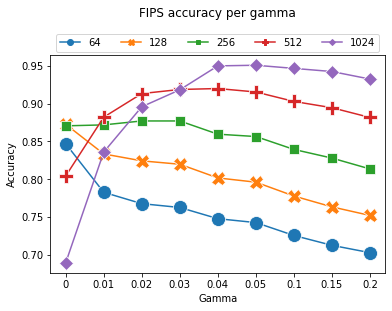

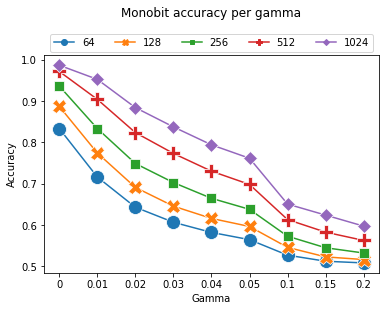

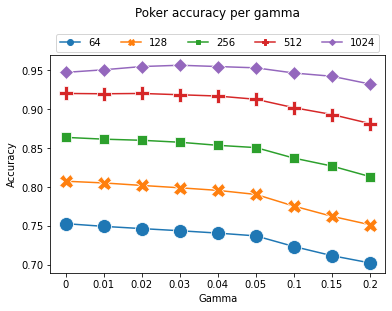

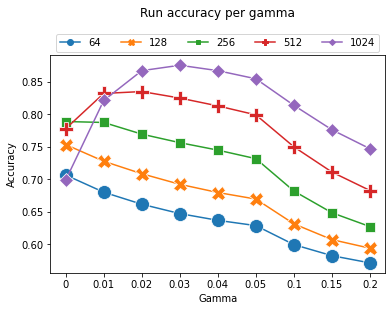

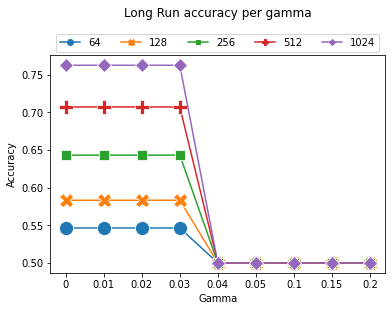

In [ ]:
def plotter_fips(d,filter):
  plt.figure()
  g = sns.lineplot(data=d, dashes=False, markers=True, markersize=14)
  g.set_xticks(range(len(gamma_fips_values))) # <--- set the ticks first
  g.set_xticklabels(['0','0.01','0.02','0.03','0.04','0.05','0.1','0.15','0.2'])
  g.set_xlabel ("Gamma")
  g.set_title (filter+" accuracy per gamma",y=1.15)
  g.set_ylabel ("Accuracy")
  g.legend(bbox_to_anchor=(0.5,1.1), loc="upper center", ncol=5,borderaxespad=0)
  plt.savefig(path+"_"+filter+"_gamma_test.png", bbox_inches='tight')


plotter_fips(dict_fips,"FIPS")
plotter_fips(dict_mono,"Monobit")
plotter_fips(dict_poker,"Poker")
plotter_fips(dict_run,"Run")
plotter_fips(dict_long,"Long Run")

The outcome of above is clear, despite the fact that we could play with the Runs test to obtain a more efficient outcome for big files, the true is that the most fiable test for the task of high entropy distinguishing is Monobit. More concretely, Monobit achieves better accuray in its most strict form (i.e. gamma 0 thus the normal setup) than the rest of tests. Note that we tried negative gamma values (thus, more strict) but the outcomes decreased dramatically. The latter may be a consequence of the definition of the FIPS values, which were developed according to the available random generator definitions.

# Experiments


In [ ]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC

IMPORTANT LETS DROP THE FEATURES THAT WE WILL NOT USE

In [ ]:
for dataset in datasets_test:
  datasets_test[dataset] = datasets_test[dataset].drop(['Fips_out', 'Run_n', 'Poker_', 'Long_run_'],axis=1)  ## we keep only monobit

In [ ]:
datasets_test[1024].columns 

Index(['Filetype', ' Original', 'Entropy', 'Jarque-Bera', 'Shapiro-Wilk',
       'Monobit_', 'Block_freq', 'Freq_average', 'Cumu_sum', 'Ov_temp',
       'Chi_score'],
      dtype='object')

##GRID and relevance features
Already done, no need to repeat. This is why we drop cols in the FIPS values and defs section

In [ ]:
##change this each time grid relevance is executed
# y=datasets_test[64].Filetype
# X=datasets_test[64].drop(['Filetype',' Original'],axis=1)
# datasize=1
# features = list(X.columns)
# print(len(features))

13


In [ ]:
model=RandomForestClassifier(oob_score=True,max_depth=10,n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['n_estimators'] = [100, 200]
grid['max_depth'] = [10, 20]
#grid['max_features'] = [1, 5, 13]
# define grid search
search = GridSearchCV(model, grid, n_jobs=-1, cv=cv)
# record current time
start = time()
# perform search
y=datasets_test[1024].Filetype
X=datasets_test[1024].drop(['Filetype',' Original'],axis=1)
search.fit(X, y)
# record current time
end = time()
# report execution time
result = end - start

print('%.3f seconds' % result)
#print(search)

40.133 seconds


In [ ]:
print('\n All results:')
print(search.cv_results_)
print('\n Best estimator:')
print(search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations')
print(search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(search.best_params_)


 All results:
{'mean_fit_time': array([0.35212548, 0.70264264, 0.37586954, 0.70886488]), 'std_fit_time': array([0.02024628, 0.03699052, 0.03887465, 0.04702891]), 'mean_score_time': array([0.10392644, 0.1049473 , 0.10357742, 0.10454126]), 'std_score_time': array([0.00136428, 0.00262492, 0.00097203, 0.00238264]), 'param_max_depth': masked_array(data=[10, 10, 20, 20],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100, 200, 100, 200],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 10, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 200}, {'max_depth': 20, 'n_estimators': 100}, {'max_depth': 20, 'n_estimators': 200}], 'split0_test_score': array([1., 1., 1., 1.]), 'split1_test_score': array([1., 1., 1., 1.]), 'split2_test_score': array([1., 1., 1., 1.]), 'split3_test_score': array([1., 1., 1., 1.]), 'split4_test_scor

In [ ]:
modelx = XGBClassifier(objective='binary:logistic')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
gridx = dict()
gridx['learning_rate'] = [0.01, 0.02]
gridx['subsample']  = [0.6, 0.8, 1.0]
gridx['max_depth']  = [4, 5]
# define grid search
searchx = GridSearchCV(modelx, gridx, n_jobs=-1, cv=cv)
# record current time
startx = time()
# perform search
searchx.fit(X, y)
# record current time
endx = time()
# report execution time
resultx = endx - startx
print('%.3f seconds' % resultx)
#print(searchx)

21.250 seconds


In [ ]:
print('\n All results:')
print(searchx.cv_results_)
print('\n Best estimator:')
print(searchx.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations')
print(searchx.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(searchx.best_params_)


 All results:
{'mean_fit_time': array([0.10589196, 0.10290905, 0.09880015, 0.10192399, 0.1041416 ,
       0.09674869, 0.10301741, 0.10240904, 0.098164  , 0.10320868,
       0.10560109, 0.09741002]), 'std_fit_time': array([0.00636861, 0.00431844, 0.00426957, 0.0019436 , 0.00667144,
       0.00321444, 0.00466471, 0.00522173, 0.00680164, 0.00390441,
       0.00633452, 0.00472663]), 'mean_score_time': array([0.00246805, 0.0024706 , 0.00267146, 0.00256565, 0.00248706,
       0.0026847 , 0.00231147, 0.00230794, 0.00251999, 0.00239436,
       0.00240085, 0.00267243]), 'std_score_time': array([0.00053896, 0.00037732, 0.00098127, 0.00142278, 0.00040431,
       0.00132686, 0.00013845, 0.00015893, 0.00060798, 0.00014185,
       0.00020566, 0.00159344]), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02,
                   0.02, 0.02, 0.02],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, Fals

##Relevance RF

The relevance of the features may slightly vary compared to the article due to the randomness of the cross validation classification. However, they will remain in very close values. 

In [ ]:
## VALS DB
vals_db=[64,128,256,512,1024]

In [ ]:
model=RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=10,n_jobs=-1)
#model.feature_names_ = features

for val in vals_db:
  plt.rcParams.update({'font.size': 14})
  y=datasets_test[val].Filetype
  X=datasets_test[val].drop(['Filetype',' Original'],axis=1)
  features = list(X.columns)
  print(len(features))


  model.fit(X, y)

  feats = {} # a dict to hold feature_name: feature_importance
  for feature, importance in zip(features, model.feature_importances_):
      feats[feature] = importance #add the name/value pair 

  importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
  importances.sort_values(by='Gini-importance').plot(kind='barh', figsize=(12,10), fontsize=24)
  print(importances.sort_values(by='Gini-importance'))
  L=plt.legend(loc='lower right')
  L.get_texts()[0].set_text('Feature importance coefficient')
  plt.title("Feature Relevance Random Forest -- "+str(val)+" KB", fontsize=28)
  
  plt.savefig(path+"features_rf_"+str(val)+".pdf", bbox_inches='tight')
  #“gini importance” or “mean decrease impurity”  is defined as the total decrease in node impurity
  # (weighted by the probability of reaching that node 
  #(which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble

##RF test
RF experiments

In [ ]:
import statistics

def calc_averages(dictio):  ##we can also do a boxplot but maybe not necessary, with the data is enough
  for key in dictio:
    dictio[key]= [statistics.mean(dictio[key]),statistics.stdev(dictio[key])]

original # 0 bin # 1 img # 2 mp3 # 3 pdf # 4 txt # 5 video

filetype   # 0 compressed  # 1 encrypted

In [ ]:
#For the best model or the selected one 
from time import time

types_files=[0,1,2,3,4,5]
df= pd.DataFrame()
for dataset in datasets_test:
  for typefile in types_files:   
    y=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].Filetype
    X=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].drop(['Filetype',' Original'],axis=1)
    features = list(X.columns)
    model=RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=10,max_features=len(features),n_jobs=-1)
    print(len(features))
    model.feature_names = features
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) ##CHANGE TO 3
      # record the current time
    start = time()
      # evaluate the model
    n_scores = cross_validate(model, X, y, scoring=['precision','recall','accuracy','f1'], cv=cv,n_jobs=-1)# FIX this to 1 to see training performances
      # record the current time
    end = time()
      # store execution time
    result = end - start
    print("Dataset with size: "+str(dataset)+" and ORIGINAL file category "+str(typefile))
    print(result)
    #print(n_scores)
    calc_averages(n_scores) ## average of all tests
    print(n_scores)
    df=df.append(pd.DataFrame.from_dict(n_scores))
df.to_csv(path+'RF_multi.csv')

9
Dataset with size: 64 and ORIGINAL file category 0
15.80219578742981
{'fit_time': [0.9356717507044474, 0.033082363808057874], 'score_time': [0.10731987158457439, 0.002876370844756851], 'test_precision': [0.9927823132764272, 0.0068321944214378635], 'test_recall': [0.9941666666666666, 0.007860127810373216], 'test_accuracy': [0.9934375, 0.004291851491388983], 'test_f1': [0.9934387341506623, 0.004295284962112166]}
9
Dataset with size: 64 and ORIGINAL file category 1
21.998268604278564
{'fit_time': [1.3295063098271689, 0.09295055237169762], 'score_time': [0.11115909417470296, 0.007775064245898667], 'test_precision': [0.8886668454474914, 0.022259181493635545], 'test_recall': [0.9779166666666667, 0.010603214650262455], 'test_accuracy': [0.9273958333333333, 0.015520845386865644], 'test_f1': [0.9310159475342354, 0.01405132056908733]}
9
Dataset with size: 64 and ORIGINAL file category 2
21.84140419960022
{'fit_time': [1.3386996587117512, 0.025603419977924074], 'score_time': [0.1077483097712199

###Plot times

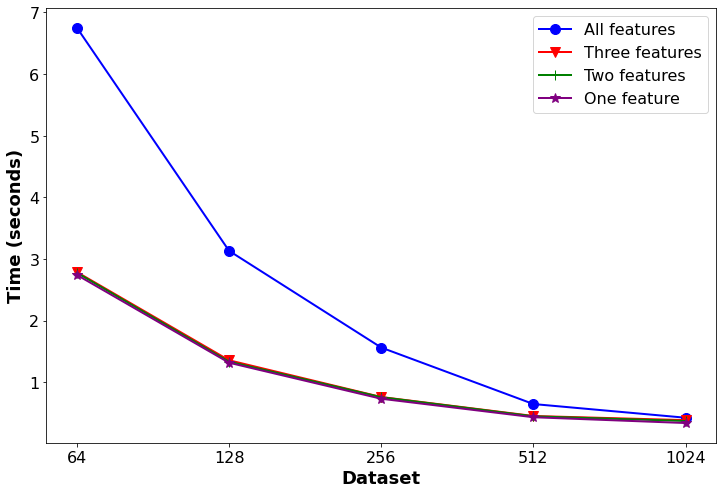

In [ ]:
all = [6.751,3.132,1.563,0.647,0.425] # average training times
three_features = [2.788,1.357,0.761,0.453,0.386] # average training times
two_features = [2.776,1.334,0.758,0.448,0.372] # average training times
one_feature = [2.741,1.317,0.733,0.433,0.339] # average training times
         
X = np.arange(len(all))
# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side



fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
plt.xticks([i + 0.25 for i in range(10)],['64','128','256','512','1024'])
plt.ylabel('Time (seconds)', weight='semibold', fontsize=18)
plt.xlabel('Dataset', weight='semibold', fontsize=18)
#ax.plot(X,Cogsec,c='r',marker="^",ls='-',label='Cognitive Security',fillstyle='none')

ax.tick_params(axis='both', which='major', labelsize=16)

ax.plot(X+.25,all,c='b',ls='-',marker="o",markersize=10, lw=2,label='All features')
ax.plot(X+.25,three_features,c='r',marker="v",markersize=10, lw=2,ls='-',label='Three features')
ax.plot(X+.25,two_features,c='green',marker="+",markersize=10, lw=2,ls='-',label='Two features')
ax.plot(X+.25,one_feature,c='purple',marker="*",markersize=10, lw=2,ls='-',label='One feature')
# ax.plot(x,x**2-1,c='m',marker="o",ls='--',label='KSTW',fillstyle='none')
# ax.plot(x,x-1,c='k',marker="+",ls=':',label='DGYC')
 
plt.legend(loc=1, fontsize=16)
plt.savefig(path+"efficiency_features_training.png", bbox_inches='tight') 
plt.show()

##Special test less features

In [ ]:
#For the best model or the selected one 
from time import time

df= pd.DataFrame()

for dataset in datasets_test:  
    y=datasets_test[dataset].Filetype
    X=datasets_test[dataset].drop(['Filetype',' Original','Jarque-Bera', 'Shapiro-Wilk', 'Block_freq', 'Freq_average', 'Cumu_sum', 'Overlapping_template'],axis=1)
    features = list(X.columns)
    model=RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=10,max_features=len(features),n_jobs=-1)
    print(len(features))
    model.feature_names = features
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) ##CHANGE TO 3
      # record the current time
    start = time()
      # evaluate the model
    n_scores = cross_validate(model, X, y, scoring=['precision','recall','accuracy','f1'], cv=cv,n_jobs=-1)# FIX this to 1 to see training performances
      # record the current time
    end = time()
      # store execution time
    result = end - start
    print("Dataset with size: "+str(dataset))
    print(result)
    #print(n_scores)
    calc_averages(n_scores) ## average of all tests
    print(n_scores)
    df=df.append(pd.DataFrame.from_dict(n_scores))
df.to_csv(path+'RF_special_few_features.csv')

3
Dataset with size: 64
61.454254150390625
{'fit_time': [3.9536415497461954, 0.15270962398765103], 'score_time': [0.11586471398671468, 0.009131657546407872], 'test_precision': [0.8911566759805967, 0.00987270296256628], 'test_recall': [0.9842013888888889, 0.004569952821409724], 'test_accuracy': [0.9319270833333333, 0.006158255636787651], 'test_f1': [0.9353347571862588, 0.005524018468338601]}
3
Dataset with size: 128
28.879319429397583
{'fit_time': [1.7897931973139445, 0.08070369671469824], 'score_time': [0.11389052867889404, 0.007025773157926695], 'test_precision': [0.9315391399771749, 0.010238625509678504], 'test_recall': [0.9902083333333334, 0.004449791742511572], 'test_accuracy': [0.9586458333333333, 0.005424052767031329], 'test_f1': [0.9599366742729664, 0.005033463423319056]}
3
Dataset with size: 256
15.58162546157837
{'fit_time': [0.9099678516387939, 0.06832433451483405], 'score_time': [0.10870527426401774, 0.0023414797979334307], 'test_precision': [0.9668372460313083, 0.0111504464

#Other tests

## SVM test


In [1]:
from time import time


model=SVC(kernel='rbf')  # linear

types_files=[0,1,2,3,4,5]
df= pd.DataFrame()
for dataset in datasets_test:
  for typefile in types_files:   
    y=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].Filetype
    X=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].drop(['Filetype',' Original'],axis=1)

    features = list(X.columns)
    print(len(features))
    model.feature_names = features
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # record the current time
    start = time()
    # evaluate the model
    n_scores = cross_validate(model, X, y, scoring=['precision','recall','accuracy','f1'], cv=cv, n_jobs=-1)# FIX this to 1 to see training performances
    # record the current time
    end = time()
    # store execution time
    result = end - start

    print("Dataset with size: "+str(dataset)+" and ORIGINAL file category "+str(typefile))
    print(result)
    print(n_scores)
    calc_averages(n_scores) ## average of all tests
    print(n_scores)
    df=df.append(pd.DataFrame.from_dict(n_scores))
df.to_csv(path+'SVC_multi.csv')

NameError: ignored

##XGB test

In [ ]:
model = XGBClassifier(objective='binary:logistic',learning_rate= 0.01, max_depth=4, subsample=0.6)


types_files=[0,1,2,3,4,5]
df= pd.DataFrame()

for dataset in datasets_test:
  for typefile in types_files:   
    y=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].Filetype
    X=datasets_test[dataset].loc[datasets_test[dataset][' Original'] == typefile].drop(['Filetype',' Original'],axis=1)
    features = list(X.columns)
    print(len(features))

    model.feature_names = features
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
      # record the current time
    start = time()
      # evaluate the model
    n_scores = cross_validate(model, X, y, scoring=['precision','recall','accuracy','f1'], cv=cv, n_jobs=-1)# FIX this to 1 to see training performances
      # record the current time
    end = time()
      # store execution time
    result = end - start
    print("Dataset with size: "+str(dataset)+" and ORIGINAL file category "+str(typefile))
    print(result)
    print(n_scores)
    calc_averages(n_scores) ## average of all tests
    print(n_scores)
    df=df.append(pd.DataFrame.from_dict(n_scores))
df.to_csv(path+'XGB_multi.csv')